### Notebook setup

In [28]:
%matplotlib inline
%autosave 30

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm

pd.set_option('display.max_rows', 10)

Autosaving every 30 seconds


### Datasets

| Dataset             | Comment                                           | Size (clicks/size)  |
|---------------------|---------------------------------------------------|---------------------|
| train.csv           | the training set                                  | 57.537.506 / 2.5 GB |
| train_sample.csv    | sample of training set                            | 100.000 / 3.9 MB |
| test.csv            | the test set                                      | 18.790.469 / 824 MB |
| test_supplement.csv | larger test set, subset used for Kaggle evaluation | 57.537.505 / 2.5GB  |


Every click record has following associated fields:
- click_time: timestamp of click (UTC)
- ip: ip address of click
- device: device type of user mobile phone
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- app: app id for marketing

Training data contains two additional fields:
- is_attributed: was app downloaded, to be predicted
- attributed_time: time of app download

For the given click data, the goal is to output the probability that the user will download the app.


Read train and test sets for local modeling and evaluation.

In [2]:
def read_dataset(path, nrows=None):
    df = pd.read_csv(path, nrows=nrows)
    df['click_time'] = pd.to_datetime(df['click_time'])
    df = df.set_index('click_time')
    df.sort_index(inplace=True)
    
    return df

dataset_train = read_dataset('data/mnt/ssd/kaggle-talkingdata2/competition_files/train_sample.csv')
dataset_test = read_dataset('data/mnt/ssd/kaggle-talkingdata2/competition_files/train.csv', nrows=1000000)
dataset_test_all = read_dataset('data/test.csv')

### Data exploration

In [3]:
dataset_train.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [4]:
ser = dataset_train.nunique()
pd.DataFrame({'attribute':ser.index, 'unique values':ser.values})

,attribute,unique values
0,ip,34857
1,app,161
2,device,100
3,os,130
4,channel,161
5,attributed_time,227
6,is_attributed,2


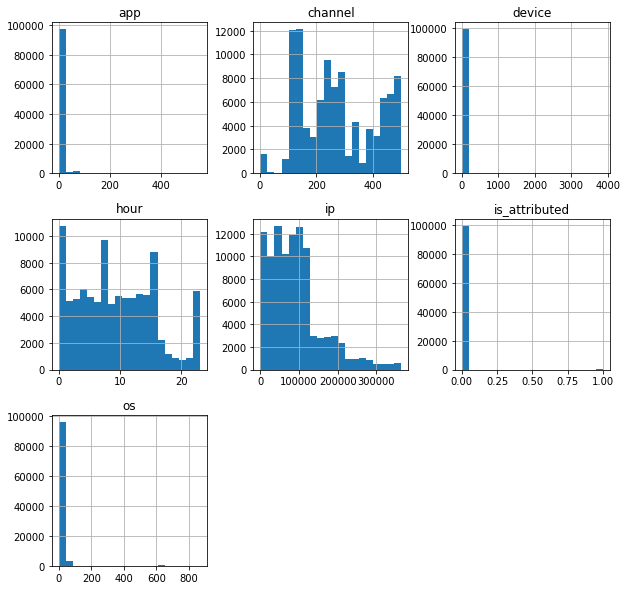

In [29]:
dataset_train.hist(bins=20, figsize=(10,10));

Distribution of `is_attributed` feature shows heavily unbalanced dataset towards no download cases.

In [30]:
corr = dataset_train.corr()
corr.style.background_gradient()

,ip,app,device,os,channel,is_attributed,hour
ip,1,0.0103998,-0.00149891,-0.000469915,0.00756287,0.0549551,-0.00795526
app,0.0103998,1,0.248376,0.24716,-0.0282377,0.064426,0.0260793
device,-0.00149891,0.248376,1,0.924456,-0.0353978,-0.000695177,0.0120347
os,-0.000469915,0.24716,0.924456,1,-0.0331755,0.00618346,0.01466
channel,0.00756287,-0.0282377,-0.0353978,-0.0331755,1,-0.0233364,-0.0213259
is_attributed,0.0549551,0.064426,-0.000695177,0.00618346,-0.0233364,1,-0.00294388
hour,-0.00795526,0.0260793,0.0120347,0.01466,-0.0213259,-0.00294388,1


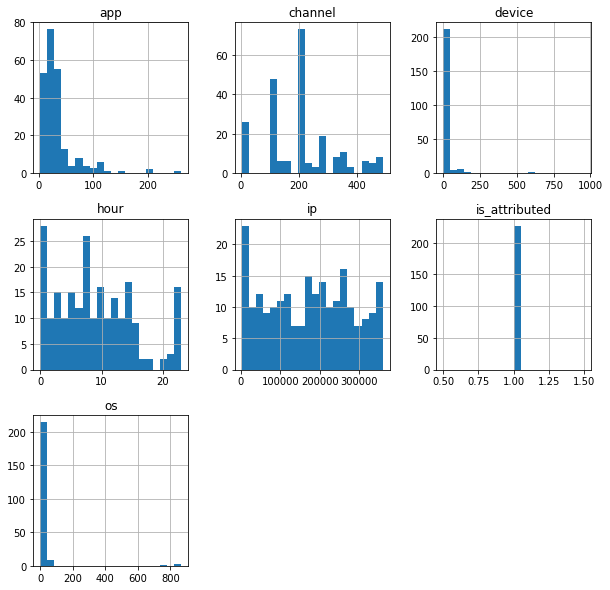

In [31]:
dataset_train[(dataset_train.is_attributed == 1)].hist(bins=20, figsize=(10,10));

In [8]:
top_apps = dataset_train.groupby(['ip'])['is_attributed'].agg(
    {"is_attributed": sum}).sort_values(
    "is_attributed", ascending=False).head(10).reset_index()
top_apps

/home/dkomlen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,ip,is_attributed
0,5348,3
1,5314,3
2,171892,1
3,346097,1
4,29016,1
5,344369,1
6,265917,1
7,35308,1
8,344551,1
9,40654,1


In [9]:
top_apps = dataset_train.groupby(['app','channel'])['is_attributed'].agg(
    {"is_attributed": sum}).sort_values(
    "is_attributed", ascending=False).head(10).reset_index()
top_apps

/home/dkomlen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,app,channel,is_attributed
0,19,213,50
1,10,113,17
2,29,213,16
3,35,21,15
4,5,113,13
5,35,274,12
6,19,347,11
7,72,101,6
8,19,282,5
9,45,5,5


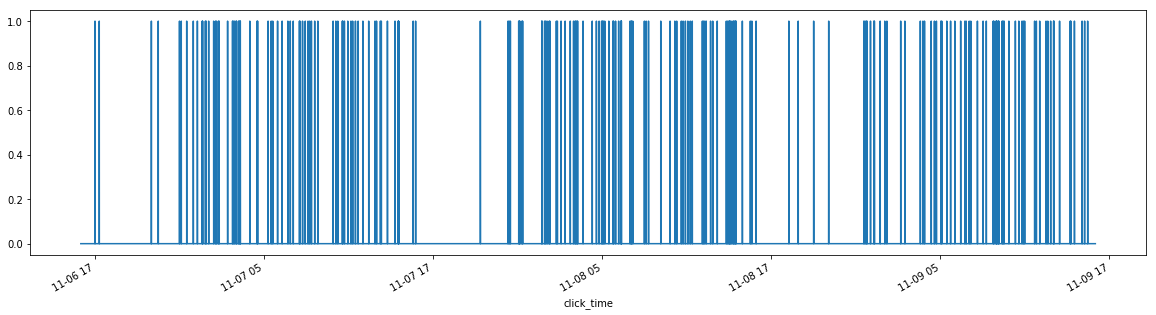

In [32]:
dataset_train.apply(lambda x: 1 if x['is_attributed'] == 1 else 0, axis=1).plot(figsize=(20, 5));

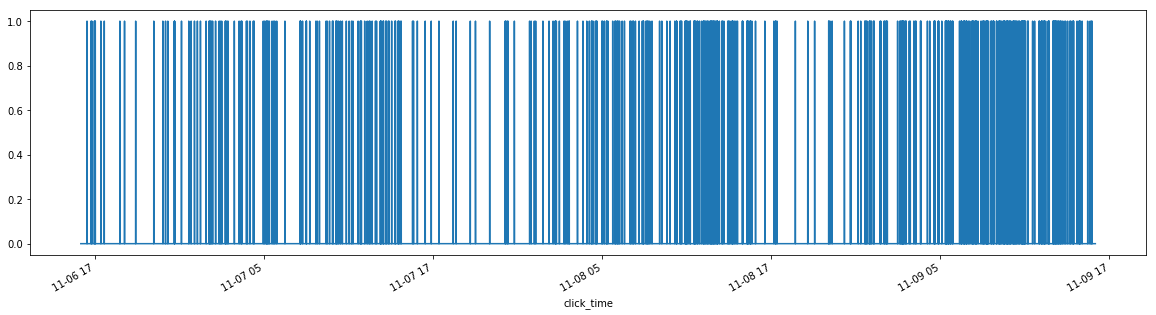

In [11]:
dataset_train.apply(lambda x: 1 if x['app'] == 19 else 0, axis=1).plot(figsize=(20, 5));

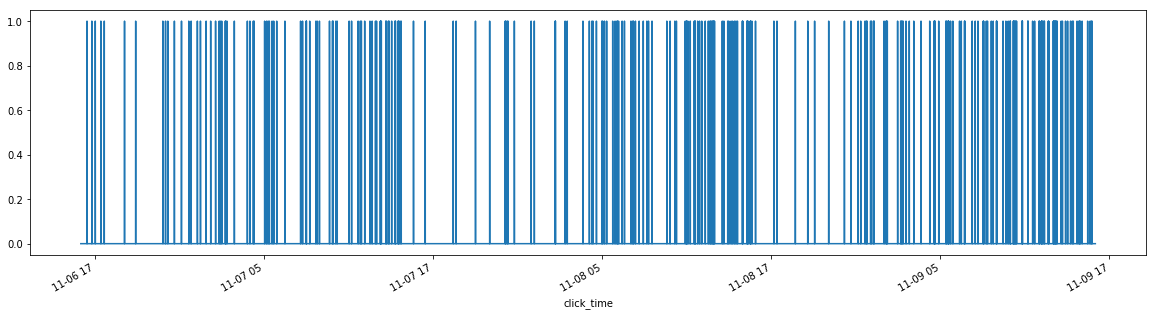

In [12]:
dataset_train.apply(lambda x: 1 if x['channel'] == 213 and x['app'] == 19 else 0, axis=1).plot(figsize=(20, 5));

### Benchmark models

For benchmark we will consider two models, one outputing constant value and second using random value from uniform distribution. Both will be evaluated on test set and the one with higher score will be used as baseline.

In [13]:
dataset_test.head()

,ip,app,device,os,channel,attributed_time,is_attributed
click_time,,,,,,,
2017-11-06 14:32:21,83230,3,1,13,379,NaN,0
2017-11-06 14:33:34,17357,3,1,19,379,NaN,0
2017-11-06 14:34:12,35810,3,1,13,379,NaN,0
2017-11-06 14:34:52,45745,14,1,13,478,NaN,0
2017-11-06 14:35:08,161007,3,1,13,379,NaN,0


In [14]:
benchmark_const = dataset_test_all[['click_id']].copy()
benchmark_const['is_attributed'] = 0
display(benchmark_const)

,click_id,is_attributed
click_time,,
2017-11-10 04:00:00,0,0
2017-11-10 04:00:00,1,0
2017-11-10 04:00:00,2,0
2017-11-10 04:00:00,3,0
2017-11-10 04:00:00,4,0
...,...,...
2017-11-10 15:00:00,18790464,0
2017-11-10 15:00:00,18790465,0
2017-11-10 15:00:00,18790467,0


In [15]:
benchmark_rand = dataset_test_all[['click_id']].copy()
benchmark_rand['is_attributed'] = np.random.uniform(size=len(benchmark_rand))
display(benchmark_rand)

,click_id,is_attributed
click_time,,
2017-11-10 04:00:00,0,0.408996
2017-11-10 04:00:00,1,0.553010
2017-11-10 04:00:00,2,0.779606
2017-11-10 04:00:00,3,0.889644
2017-11-10 04:00:00,4,0.478634
...,...,...
2017-11-10 15:00:00,18790464,0.711390
2017-11-10 15:00:00,18790465,0.220956
2017-11-10 15:00:00,18790467,0.460057


Constant model that predicts no app download scores 0.5 on Kaggle evaluator. Random model that uses uniform distribution scores 0.4995 as private score (82% of test data) and 0.5003 as public score (18% of the test data). One approach to this problem is done by [Elior Tal](https://rpubs.com/el16/410747) and his solution scores 0.825 on a subset of the test set. In his work he compares performance of random forest and boosting algorithms. We will use this as a benchmark model as it is well documented and scores better than our initial baseline models. Additionally we will use existing Kaggle solutions on the [leaderboard](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/leaderboard ) as a supporting benchmark.

### Data preprocessing

* Extract hour of the day
* For each attribute extract duration since last click with that attribute
* Remove attributes: attributed_time, click_time, is_attributed

In [22]:
from sklearn import preprocessing

def prepare_column(job):
    df = job['df']
    col = job['feat']
    
    print ('Preparing column: ', col)
    def calculate_last(row, attr, attr_map):
        attr_val = row[attr]
        if attr_val in attr_map:
            st = attr_map.get(attr_val)
            et = row['click_time']
            val = min((et - st).total_seconds(), 86400)
        else:
            val = 86400
        attr_map[attr_val] = row['click_time']
        return val

    new_col = 'last_'+col
    df[new_col] = df.apply(calculate_last, axis=1, attr=col, attr_map={})
    x = df[[new_col]].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df[new_col] = x_scaled
    return df[new_col]

def prepare_dataset(df):
    df['hour'] = df.index.hour
    df['click_time'] = df.index
    pool = mp.Pool(maxtasksperchild=1000)

    jobs = [{'df':df,'feat':feat} for feat in ['ip', 'app', 'os', 'channel', 'device']]
    with tqdm(total=len(jobs), desc="Preparing features") as pbar:
        for feat in pool.imap(prepare_column, jobs):
            df = pd.concat([df, feat], axis=1)
            pbar.update()
            
    pool.close()
    pool.join()

    return df.drop(labels=['is_attributed', 'attributed_time', 'click_time'], axis=1, errors='ignore')

In [25]:
print('Preparing train dataset')
train_y = dataset_train['is_attributed']
%time train_X = prepare_dataset(dataset_train)

print('Preparing test dataset')
test_y = dataset_test['is_attributed']
%time test_X = prepare_dataset(dataset_test)

Preparing train dataset


Preparing column:  ip
Preparing column:  app
Preparing column:  os
Preparing column:  channel
Preparing column:  device

CPU times: user 2.51 s, sys: 486 ms, total: 3 s
Wall time: 23.6 s
Preparing test dataset


Preparing column:  ip
Preparing column:  app
Preparing column:  os
Preparing column:  channel
Preparing column:  device

CPU times: user 6.91 s, sys: 2.41 s, total: 9.32 s
Wall time: 4min 10s


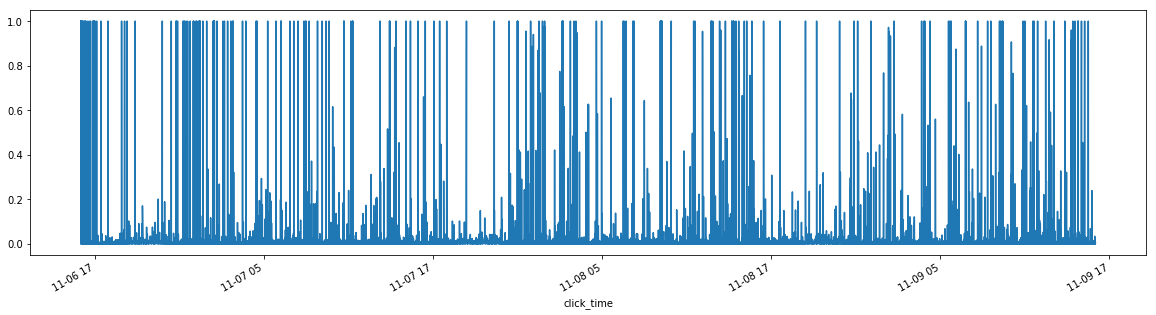

In [26]:
train_X['last_app'].plot(figsize=(20, 5));

In [19]:
train_X.tail()

,ip,app,device,os,channel,hour,last_ip,last_app,last_os,last_channel,last_device
click_time,,,,,,,,,,,
2017-11-09 15:59:42,85592,12,1,13,145,15,0.130498,0.000220,0.000035,0.000035,0.000012
2017-11-09 15:59:43,91779,18,1,41,379,15,1.000000,0.000104,0.001424,0.000556,0.000012
2017-11-09 15:59:44,81374,14,1,25,118,15,1.000000,0.000764,0.000613,0.007731,0.000012
2017-11-09 15:59:46,11911,1,1,22,115,15,1.000000,0.002373,0.000382,0.019086,0.000023
2017-11-09 15:59:51,44018,13,1,19,477,15,0.387813,0.002211,0.000336,0.001377,0.000058


Additional features to be considered adding:
- for each attribute number of clicks in previous N minutes with same attribute
value

### Model training

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression confusion matrix:


,0,1
0,998305,2
1,1693,0


GaussianNB(priors=None)

GaussianNB confusion matrix:


,0,1
0,994224,4083
1,1482,211


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

DecisionTreeClassifier confusion matrix:


,0,1
0,996123,2184
1,1245,448


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

GradientBoostingClassifier confusion matrix:


,0,1
0,998001,306
1,1572,121


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier confusion matrix:


,0,1
0,997829,478
1,1576,117


,auc,clf
0,0.562072,LogisticRegression
2,0.631216,DecisionTreeClassifier
4,0.736183,RandomForestClassifier
1,0.762397,GaussianNB
3,0.843181,GradientBoostingClassifier


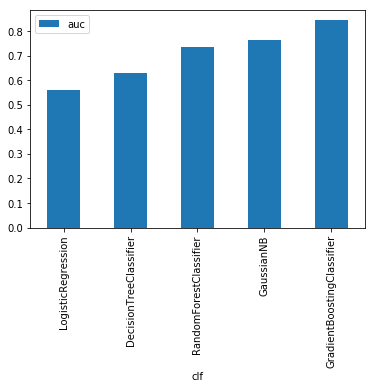

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

def evaluate_model(clf):
    predicted_proba_y = clf.predict_proba(test_X)[:,1]
    predicted_y = clf.predict(test_X)
    clf_name = str(clf).split('(')[0]
    display(clf)
    print(clf_name + ' confusion matrix:')
    display(pd.DataFrame(confusion_matrix(test_y, predicted_y)))
    return [{'clf': clf_name,
            'auc': roc_auc_score(test_y, predicted_proba_y)}]

results = []
for clf in [LogisticRegression(random_state=42), 
            GaussianNB(), 
            tree.DecisionTreeClassifier(random_state=42),
            GradientBoostingClassifier(random_state=42),
            RandomForestClassifier(random_state=42)]:
    clf.fit(train_X, train_y)
    results += evaluate_model(clf)
    
results = pd.DataFrame(results).sort_values(by=['auc'])

display(results)
results.plot.bar(x='clf');

In [60]:
%%time

# https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.externals import joblib

def optimize_model(estimator, params, cv):
    scorer = make_scorer(roc_auc_score)
    gs = GridSearchCV(estimator=estimator, param_grid=params, 
                      scoring=scorer, cv=cv, verbose=3,
                      n_jobs=-1)
    return gs.fit(train_X, train_y)

cv = StratifiedKFold(n_splits=5, shuffle=True)
model = optimize_model(GradientBoostingClassifier(), {
        'loss' : ['deviance', 'exponential'],
        'learning_rate': [0.1, 0.2, 0.3],
        'n_estimators': [50, 100, 200],
    }, cv=cv)

joblib.dump(model, 'final_model.joblib') 
display(pd.DataFrame(evaluate_model(model)))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] learning_rate=0.1, loss=deviance, n_estimators=50 ...............
[CV] learning_rate=0.1, loss=deviance, n_estimators=50 ...............
[CV] learning_rate=0.1, loss=deviance, n_estimators=50 ...............
[CV] learning_rate=0.1, loss=deviance, n_estimators=50 ...............
[CV]  learning_rate=0.1, loss=deviance, n_estimators=50, score=0.5541724314490212, total=   6.1s
[CV] learning_rate=0.1, loss=deviance, n_estimators=50 ...............
[CV]  learning_rate=0.1, loss=deviance, n_estimators=50, score=0.5440435223235665, total=   6.1s
[CV] learning_rate=0.1, loss=deviance, n_estimators=100 ..............
[CV]  learning_rate=0.1, loss=deviance, n_estimators=50, score=0.5219716584537432, total=   6.5s
[CV]  learning_rate=0.1, loss=deviance, n_estimators=50, score=0.5433780353621736, total=   6.5s
[CV] learning_rate=0.1, loss=deviance, n_estimators=100 ..............
[CV] learning_rate=0.1, loss=deviance, n_estimators=10

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.9min


[CV]  learning_rate=0.1, loss=exponential, n_estimators=100, score=0.5555555555555556, total=  28.9s
[CV] learning_rate=0.1, loss=exponential, n_estimators=200 ...........
[CV]  learning_rate=0.1, loss=exponential, n_estimators=200, score=0.5976757486954343, total=  56.6s
[CV] learning_rate=0.1, loss=exponential, n_estimators=200 ...........
[CV]  learning_rate=0.1, loss=exponential, n_estimators=200, score=0.554222544202717, total=  55.8s
[CV] learning_rate=0.2, loss=deviance, n_estimators=50 ...............
[CV]  learning_rate=0.1, loss=exponential, n_estimators=200, score=0.5775522703861465, total=  53.8s
[CV] learning_rate=0.2, loss=deviance, n_estimators=50 ...............
[CV]  learning_rate=0.2, loss=deviance, n_estimators=50, score=0.6289063436209733, total=  10.4s
[CV] learning_rate=0.2, loss=deviance, n_estimators=50 ...............
[CV]  learning_rate=0.1, loss=exponential, n_estimators=200, score=0.588663370195895, total=  51.9s
[CV] learning_rate=0.2, loss=deviance, n_esti

[CV] learning_rate=0.3, loss=exponential, n_estimators=50 ............
[CV]  learning_rate=0.3, loss=deviance, n_estimators=200, score=0.5661655140155691, total=  28.4s
[CV] learning_rate=0.3, loss=exponential, n_estimators=50 ............
[CV]  learning_rate=0.3, loss=exponential, n_estimators=50, score=0.5541974878258691, total=  11.9s
[CV] learning_rate=0.3, loss=exponential, n_estimators=50 ............
[CV]  learning_rate=0.3, loss=exponential, n_estimators=50, score=0.5433028662316298, total=  12.3s
[CV] learning_rate=0.3, loss=exponential, n_estimators=50 ............
[CV]  learning_rate=0.3, loss=exponential, n_estimators=50, score=0.5886633814972577, total=  12.0s
[CV] learning_rate=0.3, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=0.3, loss=exponential, n_estimators=50, score=0.5775522590847838, total=  12.6s
[CV] learning_rate=0.3, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=0.3, loss=exponential, n_estimators=50, score=0.55550544

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  9.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.1, 0.2, 0.3], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=3)

GridSearchCV confusion matrix:


,0,1
0,996623,1684
1,1322,371


,auc,clf
0,0.874612,GridSearchCV


CPU times: user 1min 6s, sys: 2.26 s, total: 1min 9s
Wall time: 9min 18s


In [ ]:
model.estimator

### Model evaluation

In [23]:
test_all_ids = dataset_test_all['click_id']
%time test_all_X = prepare_dataset(dataset_test_all.drop('click_id', axis=1))

Preparing column:  ip



Process ForkPoolWorker-20:
Process ForkPoolWorker-21:
Process ForkPoolWorker-19:
Process ForkPoolWorker-18:


KeyboardInterrupt: 

  File "/home/dkomlen/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dkomlen/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dkomlen/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dkomlen/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dkomlen/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/dkomlen/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dkomlen/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/dkomlen/anaconda3/lib/python3.6/multiproces

In [ ]:
from sklearn.externals import joblib

clf = joblib.load('final_model.joblib') 
test_y = clf.predict_proba(test_all_X)

In [ ]:
test_result = pd.DataFrame(test_y)

In [ ]:
test_result = pd.DataFrame(test_y[:,1], columns=['is_attributed'])
test_result['click_id'] = test_all_ids.values

test_result.to_csv('data/test_result.csv.gz',compression='gzip', index=False)

Kaggle test results:
- private score: 0.8919713
- public score: 0.8888370